In [78]:
import numpy as np
import pandas as pd

import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt

In [79]:
from collections import Counter 
plt.rcParams["figure.figsize"] = (12,12)

In [80]:
general_path = '../input/'

In [228]:
train = pd.read_csv(general_path + 'train.csv')
train['label'] = train['label'].astype('string')
train.sample(5)

image_id label
4851   1865345123.jpg     3
16011  3880530404.jpg     4
13233  3368623570.jpg     3
9136   2615629258.jpg     3
301     105315247.jpg     3

In [158]:
names_of_disease = pd.read_json(general_path + 'label_num_to_disease_map.json', typ='series')
names_of_disease

0         Cassava Bacterial Blight (CBB)
1    Cassava Brown Streak Disease (CBSD)
2             Cassava Green Mottle (CGM)
3           Cassava Mosaic Disease (CMD)
4                                Healthy
dtype: object

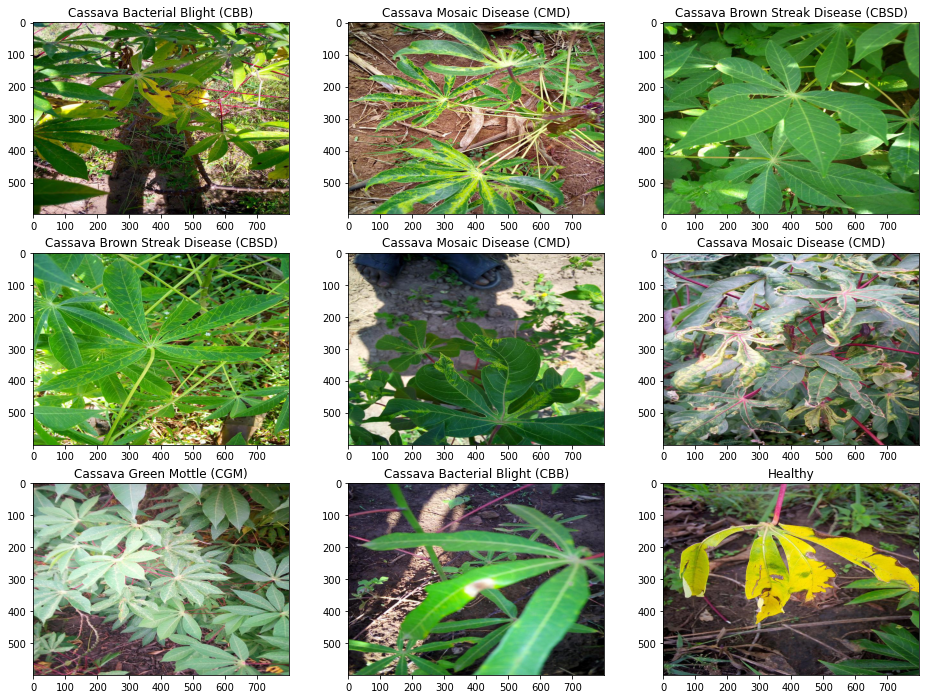

In [159]:
plt.figure(figsize=(16, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = Image.open(general_path + 'train_images/' + train.iloc[i]['image_id'])
    array = np.array(image)
    plt.imshow(array)
    label=train.iloc[i]['label']
    plt.title(f'{names_of_disease[int(label)]}')
plt.show()

In [160]:
sizes = []
for i in range(1, len(train), 250):
    image = Image.open(general_path + 'train_images/' + train.iloc[i]['image_id'])
    array = np.array(image)
    sizes.append(array.shape)
print('Picture size', set(sizes))

Picture size {(600, 800, 3)}


In [161]:
img_width, img_height = 456, 456

In [229]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator()
train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=train,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=120,
    subset='training',
    seed=12345)

Found 21397 validated image filenames belonging to 5 classes.


In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
                             vertical_flip=True,
                             horizontal_flip=True)
train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=train,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=20,
    subset='training',
    seed=12345)

Found 17118 validated image filenames belonging to 5 classes.


In [105]:
valid_datagen_flow = datagen.flow_from_dataframe(
    dataframe=train,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=120,
    subset='validation',
    seed=12345)

Found 4279 validated image filenames belonging to 5 classes.


In [10]:
current_balance = train['label'].value_counts(normalize=True)
current_balance

3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64

In [ ]:
class_weight = {0: (1 - current_balance['0']) / (1 - current_balance.min()),
                1: (1 - current_balance['1']) / (1 - current_balance.min()),
                2: (1 - current_balance['2']) / (1 - current_balance.min()),
                3: (1 - current_balance['3']) / (1 - current_balance.min()),
                4: (1 - current_balance['4']) / (1 - current_balance.min())}

class_weight

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [14]:
import efficientnet.keras as eff
from tensorflow.keras.experimental import CosineDecay

In [250]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.math.add(y_pred, epsilon)
        ce = tf.math.multiply(y_true, -tf.math.log(model_out))
        weight = tf.math.multiply(y_true, tf.math.pow(tf.math.subtract(1., model_out), gamma))
        fl = tf.math.multiply(alpha, tf.math.multiply(weight, ce))
        reduced_fl = tf.math.reduce_max(fl, axis=1)
        return tf.math.reduce_mean(reduced_fl)
    return focal_loss_fixed

def focal_loss_fixed(y_true, y_pred):
    """Focal loss for multi-classification
    FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
    Notice: y_pred is probability after softmax
    gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
    d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
    Focal Loss for Dense Object Detection
    https://arxiv.org/abs/1708.02002

    Arguments:
        y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
        y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

    Keyword Arguments:
        gamma {float} -- (default: {2.0})
        alpha {float} -- (default: {4.0})

    Returns:
        [tensor] -- loss.
    """
    epsilon = 1.e-9
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)

    model_out = tf.math.add(y_pred, epsilon)
    ce = tf.math.multiply(y_true, -tf.math.log(model_out))
    weight = tf.math.multiply(y_true, tf.math.pow(tf.math.subtract(1., model_out), gamma))
    fl = tf.math.multiply(alpha, tf.math.multiply(weight, ce))
    reduced_fl = tf.math.reduce_max(fl, axis=1)
    return tf.math.reduce_mean(reduced_fl)

CLASSES = ['0', '1', '2', '3', '4']
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 8
EPOCHS = 25

decay_steps = int(round(17118/BATCH_SIZE))*EPOCHS
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

from keras.backend import sigmoid

class SwishActivation(tf.keras.layers.Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
# from tf.keras.layers import Activation
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})


inputs = tf.keras.layers.Input(shape=(img_width, img_height, 3))

model = eff.EfficientNetB4(include_top=False, input_tensor=inputs, weights='noisy-student')


# Freeze the pretrained weights
# model.trainable = False

# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(swish_act)(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(swish_act)(x)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

#     model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(cosine_decay), 
#               metrics=["accuracy"])
# model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(cosine_decay), 
#               metrics=["accuracy"])

model.compile(loss=focal_loss(), optimizer=tf.keras.optimizers.Adam(cosine_decay), 
              metrics=["accuracy"])

In [251]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 228, 228, 48) 1296        input_6[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 228, 228, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 228, 228, 48) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [252]:
# history = model.fit(train_datagen_flow,
#                     validation_data=valid_datagen_flow, 
#                     epochs=EPOCHS,
#                     class_weight=class_weight,
#                     callbacks=[early_stopping, mc],)

In [253]:
# model = tf.keras.models.load_model('/home/usmanr/workspace/cassava/model_456x456_2/EfficientNet_B4_1.h5')

# model = tf.keras.models.load_model('/home/usmanr/Downloads/EfficientNetB4_half_helthy.h5')

# model = tf.keras.models.load_model('/home/usmanr/Downloads/EfficientNetB4_double_helthy.h5')

model = tf.keras.models.load_model('/home/usmanr/Downloads/EfficientNetB4_focal_loss_equal_weight.h5')

ValueError: Unknown loss function: focal_loss_fixed

In [230]:
# for _ in range(4279//20):
labels = []
preds = []
filenames = []
    
for step, (x_batch_train, y_batch_train) in enumerate(train_datagen_flow):
    labels+=y_batch_train.tolist()
    pred = model.predict(x_batch_train)
    preds+=pred.tolist()
    filenames+=train_datagen_flow.filenames[step*120:(step+1)*120]
    print(step)
    if (step + 1) * 120 > 21397:break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178


In [231]:
len(filenames)

21397

In [232]:
# names_of_disease = names_of_disease.to_dict()

In [233]:
names_of_disease

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [234]:
breaking_point = 0
bad_labels = []
bad_images = []
index = []

for i in range(len(filenames)):
#     if np.argmax(labels[i]) != np.argmax(preds[i]):
    if max(preds[i]) < 0.6:
        print(names_of_disease[np.argmax(labels[i])], preds[i], filenames[i])
        bad_labels.append(names_of_disease[np.argmax(labels[i])])
        bad_images.append(filenames[i])
        index.append(i)
#         image = Image.open(general_path + 'train_images/' + filenames[i])
#         plt.imshow(image)
#         plt.show()
        breaking_point+=1
#     if breaking_point > 20:
#         print(i)
#         break

print(breaking_point)

Cassava Mosaic Disease (CMD) [0.03528641164302826, 0.016949661076068878, 0.016716955229640007, 0.41426339745521545, 0.5167835354804993] 1001723730.jpg
Cassava Mosaic Disease (CMD) [0.03324273228645325, 0.05216050148010254, 0.048269305378198624, 0.5760090947151184, 0.2903183102607727] 1001742395.jpg
Healthy [0.43482863903045654, 0.03802672028541565, 0.013255463913083076, 0.003159712068736553, 0.5107294321060181] 1003442061.jpg
Healthy [0.20238938927650452, 0.2201138436794281, 0.03158140182495117, 0.006912533193826675, 0.5390028357505798] 100609661.jpg
Healthy [0.020272916182875633, 0.389864444732666, 0.020846812054514885, 0.07490845024585724, 0.4941074252128601] 1010470173.jpg
Cassava Brown Streak Disease (CBSD) [0.14583808183670044, 0.5838757157325745, 0.07964149117469788, 0.06246703118085861, 0.1281777173280716] 1012804587.jpg
Cassava Mosaic Disease (CMD) [0.12009970098733902, 0.10018254816532135, 0.02690010704100132, 0.3043946921825409, 0.44842299818992615] 1016334938.jpg
Cassava Bro

Healthy [0.01637059450149536, 0.014231731183826923, 0.3508659303188324, 0.4057406783103943, 0.21279104053974152] 2168109133.jpg
Cassava Mosaic Disease (CMD) [0.022363532334566116, 0.38809359073638916, 0.051796115934848785, 0.4305403232574463, 0.10720646381378174] 217326166.jpg
Cassava Mosaic Disease (CMD) [0.03027135506272316, 0.04176870733499527, 0.3890923857688904, 0.49722397327423096, 0.041643597185611725] 2178423983.jpg
Healthy [0.3876362442970276, 0.07258401066064835, 0.01502236444503069, 0.008442074060440063, 0.5163153409957886] 2179468784.jpg
Cassava Bacterial Blight (CBB) [0.5985761880874634, 0.08433442562818527, 0.03031691163778305, 0.0013230849290266633, 0.28544944524765015] 2181796105.jpg
Healthy [0.045584384351968765, 0.5201351046562195, 0.09225508570671082, 0.008046584203839302, 0.3339788317680359] 2190685942.jpg
Healthy [0.04047989472746849, 0.014454558491706848, 0.44757306575775146, 0.007045069709420204, 0.49044737219810486] 2191259064.jpg
Healthy [0.450834721326828, 0.0

Healthy [0.03323521837592125, 0.08959624916315079, 0.036642078310251236, 0.36452147364616394, 0.4760049283504486] 3239751469.jpg
Cassava Bacterial Blight (CBB) [0.5142070651054382, 0.12168582528829575, 0.3191035985946655, 0.016625870019197464, 0.02837768942117691] 3243126254.jpg
Healthy [0.5247891545295715, 0.15665794909000397, 0.011411648243665695, 0.011571343056857586, 0.29556986689567566] 3247597074.jpg
Cassava Bacterial Blight (CBB) [0.5755943059921265, 0.05179981142282486, 0.016377050429582596, 0.0021088123321533203, 0.3541199564933777] 3250352507.jpg
Cassava Mosaic Disease (CMD) [0.016742296516895294, 0.44266602396965027, 0.017607400193810463, 0.5126345753669739, 0.01034963596612215] 3250432393.jpg
Healthy [0.164142906665802, 0.5961449146270752, 0.08615942299365997, 0.003797622863203287, 0.14975515007972717] 3250565385.jpg
Cassava Mosaic Disease (CMD) [0.02179659716784954, 0.036705803126096725, 0.3565790355205536, 0.485191285610199, 0.09972725063562393] 3251764098.jpg
Cassava Mos

Healthy [0.10300533473491669, 0.3760131597518921, 0.04229917377233505, 0.011265016160905361, 0.46741726994514465] 470266437.jpg
Cassava Green Mottle (CGM) [0.0525018684566021, 0.12682318687438965, 0.46163877844810486, 0.029919356107711792, 0.3291167914867401] 472269630.jpg
Cassava Brown Streak Disease (CBSD) [0.04543054848909378, 0.1618148386478424, 0.04368886351585388, 0.15800032019615173, 0.5910654664039612] 476012362.jpg
Cassava Bacterial Blight (CBB) [0.2464146465063095, 0.32211393117904663, 0.23497968912124634, 0.008580789901316166, 0.18791092932224274] 479691451.jpg
Cassava Mosaic Disease (CMD) [0.021743547171354294, 0.3539712429046631, 0.02143481932580471, 0.5737115740776062, 0.029138831421732903] 480419575.jpg
Cassava Mosaic Disease (CMD) [0.0354497916996479, 0.20987695455551147, 0.10602125525474548, 0.5499871969223022, 0.09866488724946976] 481585072.jpg
Cassava Mosaic Disease (CMD) [0.026661060750484467, 0.2999078035354614, 0.03255334496498108, 0.5987116098403931, 0.0421661660

In [ ]:
VALID_FILENAMES = ['gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train02-1338.tfrec',
 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train15-1327.tfrec',
 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train05-1338.tfrec',
 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train00-1338.tfrec']

In [235]:
bad_labels[0]

'Cassava Mosaic Disease (CMD)'

In [236]:
[ (i,bad_labels.count(i)) for i in set(bad_labels) ]

[('Cassava Mosaic Disease (CMD)', 652),
 ('Healthy', 589),
 ('Cassava Green Mottle (CGM)', 266),
 ('Cassava Bacterial Blight (CBB)', 369),
 ('Cassava Brown Streak Disease (CBSD)', 344)]

In [207]:
print(labels[index[0]])
print(preds[index[0]])

[0.0, 0.0, 0.0, 1.0, 0.0]
[0.027635106816887856, 0.0640500858426094, 0.47930559515953064, 0.406184583902359, 0.02282467857003212]


[0.0, 1.0, 0.0, 0.0, 0.0]
[0.01844916120171547, 0.24032659828662872, 0.17668016254901886, 0.2721148133277893, 0.2924292981624603]


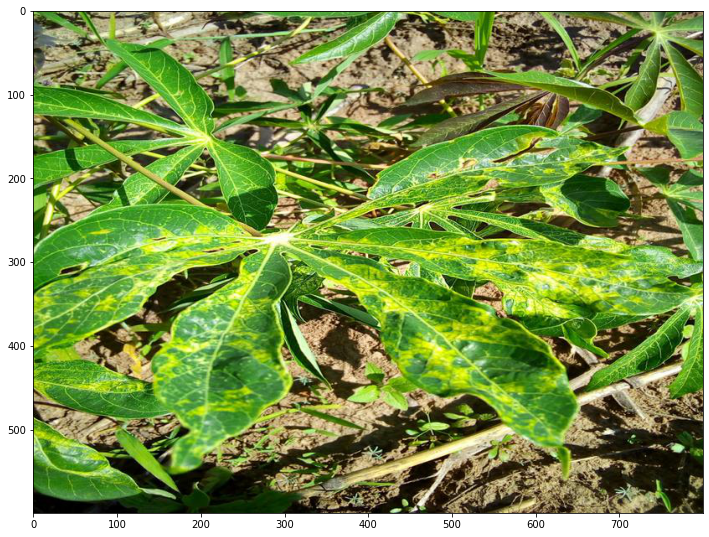

In [208]:
task = 30
print(labels[index[task]])
print(preds[index[task]])

image = Image.open(general_path + 'train_images/' + bad_images[task])
plt.imshow(image)

In [184]:
for b in bad_images:
    print(b+',',  end='')

1004672608.jpg,100609661.jpg,1008244905.jpg,1009037539.jpg,101253257.jpg,1014888611.jpg,1020636424.jpg,1022475063.jpg,1023151050.jpg,1025492337.jpg,1025511060.jpg,1025557405.jpg,1028041356.jpg,102968016.jpg,1034577161.jpg,1034735631.jpg,103776422.jpg,1040156603.jpg,1041184552.jpg,1041922165.jpg,1042223039.jpg,1042661635.jpg,1043238803.jpg,1045208006.jpg,104535906.jpg,10459387.jpg,1046703257.jpg,1048686894.jpg,1048738679.jpg,1048872437.jpg,1050847556.jpg,1052095724.jpg,1052118637.jpg,1053293117.jpg,1054232796.jpg,105602329.jpg,1059334615.jpg,1061187521.jpg,106169527.jpg,1064213029.jpg,1070630875.jpg,1072929806.jpg,1074333151.jpg,1078061341.jpg,10780620.jpg,1078497809.jpg,1079224858.jpg,1079793899.jpg,1083681960.jpg,1084229234.jpg,1085038226.jpg,1085879366.jpg,1088631003.jpg,1090285146.jpg,1091388730.jpg,1091452653.jpg,1092289858.jpg,1094476490.jpg,1094769327.jpg,1095991625.jpg,109787893.jpg,1098184586.jpg,110051175.jpg,1101262562.jpg,1103037453.jpg,110359894.jpg,1104367012.jpg,11054682.

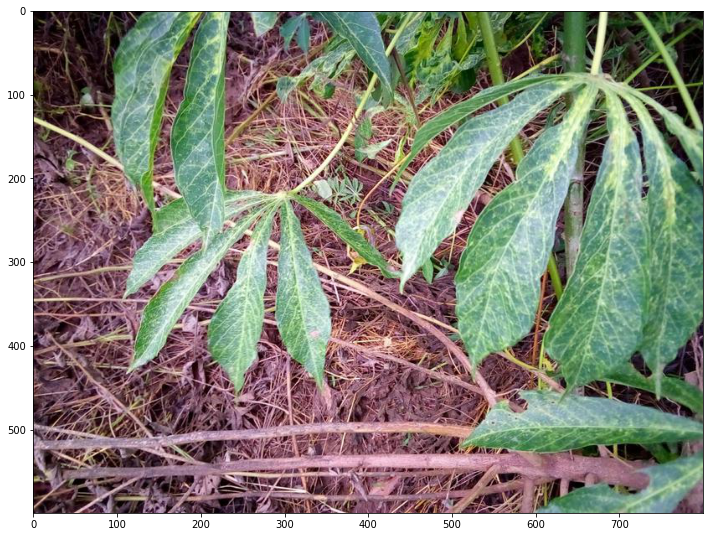

In [197]:
image = Image.open(general_path + 'train_images/' + bad_images[23])
plt.imshow(image)

In [58]:
labels[0]

[0.0, 0.0, 0.0, 1.0, 0.0]

In [59]:
preds[0]

[0.01738087460398674,
 0.017380453646183014,
 0.016070328652858734,
 0.9038370847702026,
 0.04533125460147858]

In [150]:
model.save_weights('EfficientNetB4_retrain.cpkt')

In [44]:
y_batch_train.shape

(20, 5)

In [19]:
pred = model.predict(x)

In [49]:
pred

array([[0.02197541, 0.01483808, 0.01701176, 0.940987  , 0.0051877 ],
       [0.67210096, 0.03007521, 0.01924119, 0.00867473, 0.2699079 ],
       [0.01284891, 0.02028933, 0.04378998, 0.9066427 , 0.01642905],
       [0.02066309, 0.01456067, 0.02355565, 0.5938551 , 0.3473655 ],
       [0.00352573, 0.9589096 , 0.00491479, 0.00596955, 0.0266804 ],
       [0.02010355, 0.02093077, 0.8744618 , 0.06717914, 0.01732471],
       [0.6789744 , 0.01720297, 0.00659565, 0.00244577, 0.29478118],
       [0.01930558, 0.26201117, 0.02090506, 0.6825032 , 0.015275  ],
       [0.02395714, 0.01741345, 0.01183528, 0.9352527 , 0.01154145],
       [0.01594969, 0.02708768, 0.93000233, 0.01193611, 0.01502419],
       [0.01800541, 0.01292897, 0.01297392, 0.945914  , 0.01017772],
       [0.02169243, 0.0214162 , 0.01438823, 0.93163455, 0.01086867],
       [0.75962675, 0.0267961 , 0.0176246 , 0.02234837, 0.17360425],
       [0.02224154, 0.01798733, 0.01809271, 0.93239605, 0.00928241],
       [0.01391883, 0.03785859, 0.

In [26]:
[np.argmax(p) for p in pred]

[3, 0, 3, 3, 1, 2, 0, 3, 3, 2, 3, 3, 0, 3, 3, 4, 3, 3, 3, 3]

In [28]:
[np.argmax(p) for p in y]

[3, 0, 3, 3, 1, 2, 0, 3, 3, 2, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3]

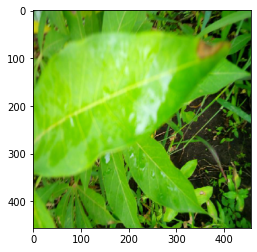

In [29]:
plt.imshow(x[12]/255.0)

In [40]:
labels = []
preds = []

labels+=y.tolist()
labels+=y.tolist()

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt

In [5]:
general_path = '../input/'

In [115]:
train = pd.read_csv(general_path + 'train.csv')
train['label'] = train['label'].astype('string')
train.sample(5)

image_id label
16300   393700734.jpg     3
16242   392503327.jpg     4
5532   1984779021.jpg     4
6231   2115357575.jpg     3
1891   1334282465.jpg     4

In [209]:
bad_images = """1004672608.jpg,100609661.jpg,1008244905.jpg,1009037539.jpg,101253257.jpg,1014888611.jpg,1020636424.jpg,1022475063.jpg,1023151050.jpg,1025492337.jpg,1025511060.jpg,1025557405.jpg,1028041356.jpg,102968016.jpg,1034577161.jpg,1034735631.jpg,103776422.jpg,1040156603.jpg,1041184552.jpg,1041922165.jpg,1042223039.jpg,1042661635.jpg,1043238803.jpg,1045208006.jpg,104535906.jpg,10459387.jpg,1046703257.jpg,1048686894.jpg,1048738679.jpg,1048872437.jpg,1050847556.jpg,1052095724.jpg,1052118637.jpg,1053293117.jpg,1054232796.jpg,105602329.jpg,1059334615.jpg,1061187521.jpg,106169527.jpg,1064213029.jpg,1070630875.jpg,1072929806.jpg,1074333151.jpg,1078061341.jpg,10780620.jpg,1078497809.jpg,1079224858.jpg,1079793899.jpg,1083681960.jpg,1084229234.jpg,1085038226.jpg,1085879366.jpg,1088631003.jpg,1090285146.jpg,1091388730.jpg,1091452653.jpg,1092289858.jpg,1094476490.jpg,1094769327.jpg,1095991625.jpg,109787893.jpg,1098184586.jpg,110051175.jpg,1101262562.jpg,1103037453.jpg,110359894.jpg,1104367012.jpg,11054682.jpg,1105650232.jpg,1106559016.jpg,1109418037.jpg,1109793764.jpg,1109928772.jpg,1112568678.jpg,1113324991.jpg,1113813904.jpg,1114588792.jpg,111755849.jpg,1118049363.jpg,1118628939.jpg,1120416975.jpg,1120985228.jpg,1121048541.jpg,1123269893.jpg,1125560878.jpg,1127286868.jpg,1127352598.jpg,1127545108.jpg,1127648735.jpg,1129442307.jpg,1130848139.jpg,1131545521.jpg,1131959133.jpg,1132352696.jpg,1134422280.jpg,1140116873.jpg,114251805.jpg,1143022454.jpg,1145076372.jpg,1145667404.jpg,1148976891.jpg,1149243998.jpg,1150289394.jpg,1150608601.jpg,1151756938.jpg,1152631724.jpg,1158902447.jpg,1160075077.jpg,1161718761.jpg,116338302.jpg,116466028.jpg,1166973570.jpg,1171643139.jpg,117226420.jpg,1172621803.jpg,1174286080.jpg,1177074840.jpg,1178068241.jpg,1178307457.jpg,117837871.jpg,1179134330.jpg,1179452457.jpg,1180011069.jpg,1181577348.jpg,1182217128.jpg,1185052767.jpg,1188511483.jpg,1190620431.jpg,1191499624.jpg,1192463815.jpg,1192486665.jpg,119590613.jpg,1197890857.jpg,119881246.jpg,1203285369.jpg,1205478806.jpg,1205963821.jpg,1211187400.jpg,1212399275.jpg,1220118716.jpg,1220597062.jpg,1221664353.jpg,1222730682.jpg,122288577.jpg,1228781460.jpg,1231451126.jpg,1232852695.jpg,1234571117.jpg,1234931385.jpg,1237914743.jpg,1238597078.jpg,123865158.jpg,1239270828.jpg,1240401949.jpg,1241084858.jpg,1241243048.jpg,1242261081.jpg,1246876543.jpg,1251667319.jpg,125207834.jpg,1252142336.jpg,1252538311.jpg,1252720161.jpg,125475896.jpg,1257929885.jpg,1258505000.jpg,1258508279.jpg,126058013.jpg,1263625799.jpg,1266982278.jpg,1267796913.jpg,1268162819.jpg,1268317918.jpg,1268809916.jpg,1269528724.jpg,1269550303.jpg,1269638182.jpg,1271824448.jpg,1272495783.jpg,1273363177.jpg,1276952217.jpg,1277358374.jpg,127742871.jpg,1277679675.jpg,1279364304.jpg,1279384269.jpg,1281314946.jpg,1281527517.jpg,1284148713.jpg,1287942179.jpg,1292410663.jpg,1292512512.jpg,1292573857.jpg,1298789590.jpg,1302078468.jpg,1302328544.jpg,1302565676.jpg,130292235.jpg,1305777482.jpg,1306087922.jpg,1308168920.jpg,1309142410.jpg,1314192396.jpg,1315280013.jpg,1315797481.jpg,1316381206.jpg,1316805765.jpg,1317481628.jpg,1320401376.jpg,1329605336.jpg,1331226893.jpg,1331843412.jpg,1332005593.jpg,1332476551.jpg,1332855741.jpg,133303828.jpg,1333580402.jpg,1336010975.jpg,1339606936.jpg,1340066568.jpg,1342351547.jpg,1343351739.jpg,1344445533.jpg,1345845382.jpg,134649425.jpg,1351107060.jpg,1352386013.jpg,1352878479.jpg,135365403.jpg,1354001742.jpg,1354318448.jpg,1355063606.jpg,1356339693.jpg,1356643754.jpg,1359809318.jpg,1359844717.jpg,1359969815.jpg,1361129876.jpg,1362265434.jpg,1365404548.jpg,1365612235.jpg,1366570105.jpg,1367847379.jpg,1368162685.jpg,1368384368.jpg,1372417670.jpg,1378105752.jpg,1379189798.jpg,137921395.jpg,1381916877.jpg,1382329644.jpg,1383020993.jpg,1383579851.jpg,1386736977.jpg,1387999254.jpg,1389283574.jpg,139047883.jpg,1391150010.jpg,139601828.jpg,1396114117.jpg,1402491391.jpg,1402508321.jpg,1403274115.jpg,140350208.jpg,1404479334.jpg,1407032343.jpg,1407720026.jpg,1410638110.jpg,1412272619.jpg,1415276331.jpg,1416272901.jpg,1416367019.jpg,1416607824.jpg,1417496054.jpg,1418701712.jpg,1418896988.jpg,1419674728.jpg,1421062396.jpg,14227104.jpg,1424785333.jpg,1425848299.jpg,1427151109.jpg,1427453131.jpg,1431052836.jpg,1432403578.jpg,1433061380.jpg,1436413250.jpg,1436605997.jpg,1447310792.jpg,1454074626.jpg,1454850686.jpg,1457223613.jpg,1457225378.jpg,146450021.jpg,1465359996.jpg,1468716858.jpg,1473438422.jpg,1479257856.jpg,147932460.jpg,1481071460.jpg,1482562334.jpg,148469667.jpg,1485335587.jpg,1486476402.jpg,1489138795.jpg,1489666486.jpg,1490907378.jpg,1492594056.jpg,1492704954.jpg,1493949319.jpg,1496279708.jpg,1496786758.jpg,1497799028.jpg,149926175.jpg,1500739186.jpg,1506979895.jpg,1508217938.jpg,1512350296.jpg,1515921207.jpg,1517270084.jpg,15177566.jpg,1519424592.jpg,1519602849.jpg,1520672258.jpg,1522024247.jpg,1522449555.jpg,1523865421.jpg,1524278014.jpg,1524527135.jpg,152558595.jpg,1526090875.jpg,1528321401.jpg,1530287457.jpg,1530992994.jpg,1531777334.jpg,153193578.jpg,1533215166.jpg,1535644192.jpg,1537091339.jpg,1537830611.jpg,1539957701.jpg,1544883510.jpg,1546329958.jpg,1546491246.jpg,1548022492.jpg,1548749021.jpg,1549275495.jpg,1550678454.jpg,1552589492.jpg,1552938679.jpg,155869794.jpg,156080014.jpg,1561430411.jpg,1562043567.jpg,1564696319.jpg,1569385189.jpg,157425630.jpg,1576152560.jpg,1576603562.jpg,1581350775.jpg,1582998672.jpg,1584105518.jpg,1585833498.jpg,1586131534.jpg,158743924.jpg,1587572009.jpg,1588060521.jpg,1588291384.jpg,1589092032.jpg,1591076674.jpg,1592847441.jpg,1594527839.jpg,1595079320.jpg,1595485153.jpg,1595574343.jpg,1596461528.jpg,15982075.jpg,1601545456.jpg,1601764877.jpg,1603131722.jpg,1610155369.jpg,1610632486.jpg,1611894117.jpg,1618418212.jpg,1620520696.jpg,1621255319.jpg,1622070201.jpg,1623430367.jpg,1631620098.jpg,1633693725.jpg,1634210078.jpg,1634561629.jpg,1635220625.jpg,1641250084.jpg,1641316249.jpg,164643516.jpg,1647523800.jpg,1650008995.jpg,16503141.jpg,165230387.jpg,1654334807.jpg,1654777863.jpg,1655630395.jpg,1658025063.jpg,1660278504.jpg,1666313319.jpg,1667719250.jpg,1668160531.jpg,1671607794.jpg,1676052292.jpg,1676416724.jpg,1679233615.jpg,1689577139.jpg,1692979683.jpg,1695268361.jpg,1697842534.jpg,1700324452.jpg,1700592380.jpg,1702253388.jpg,1704757491.jpg,1704903171.jpg,1710187645.jpg,1710700756.jpg,1712458333.jpg,1713403658.jpg,1713444587.jpg,1714717170.jpg,1715574145.jpg,1715814415.jpg,1722781074.jpg,1723081246.jpg,172324679.jpg,1726694302.jpg,172872674.jpg,1728958527.jpg,1729933638.jpg,173019618.jpg,1730671477.jpg,1731652110.jpg,1735806494.jpg,1735838200.jpg,1735911943.jpg,1736794140.jpg,1739927380.jpg,1740009337.jpg,1741630532.jpg,1742577846.jpg,1744132907.jpg,174581727.jpg,174674584.jpg,1748255784.jpg,1748314267.jpg,1748519439.jpg,1752693374.jpg,175398874.jpg,1757386939.jpg,1757646120.jpg,1758274933.jpg,1758913732.jpg,1759042176.jpg,1760111607.jpg,1760414048.jpg,1761893158.jpg,1765114818.jpg,176531736.jpg,1767778795.jpg,1772478144.jpg,1773462617.jpg,1781156420.jpg,1781447464.jpg,1782983052.jpg,1784226798.jpg,1788926581.jpg,1790610491.jpg,1791700029.jpg,1796126555.jpg,1798415301.jpg,1802508865.jpg,1803055979.jpg,1803422865.jpg,1805270227.jpg,1811402818.jpg,181157076.jpg,1812204593.jpg,181228632.jpg,1813889006.jpg,1817411055.jpg,1822627582.jpg,1823544531.jpg,1824287001.jpg,1824705261.jpg,1829924843.jpg,1833515952.jpg,1834604055.jpg,1837309847.jpg,1840585647.jpg,1842263776.jpg,1844689263.jpg,1847878372.jpg,1847948154.jpg,1848686439.jpg,1849248641.jpg,1850235748.jpg,1851047251.jpg,18547180.jpg,1856744348.jpg,1858778383.jpg,1859104179.jpg,1859785937.jpg,1860402605.jpg,1861027492.jpg,1865586599.jpg,1867337976.jpg,1867590389.jpg,1868574400.jpg,1870220929.jpg,1873100849.jpg,187343662.jpg,1880623255.jpg,188217517.jpg,1884379874.jpg,1887611865.jpg,1889645110.jpg,1890473397.jpg,1891755915.jpg,1892378935.jpg,1892715809.jpg,1896242040.jpg,1897331783.jpg,1900332418.jpg,190054871.jpg,1903950320.jpg,1903992787.jpg,190439528.jpg,1907138537.jpg,1907269617.jpg,1908074016.jpg,1908512219.jpg,1911224760.jpg,1916496572.jpg,1916638324.jpg,1919707179.jpg,1927268633.jpg,1927862563.jpg,1928678720.jpg,1929477466.jpg,1930146002.jpg,1930227281.jpg,1931522080.jpg,1938616867.jpg,1939113672.jpg,193958679.jpg,1940410728.jpg,1940934200.jpg,1941569739.jpg,1942531385.jpg,1943999614.jpg,1945153538.jpg,1947542350.jpg,1948267522.jpg,1948579246.jpg,1948688497.jpg,1949350366.jpg,1951284903.jpg,1951432594.jpg,1951968907.jpg,1955288492.jpg,1957897144.jpg,1960041118.jpg,1964845483.jpg,1964957251.jpg,196827889.jpg,1968615575.jpg,1969585969.jpg,1969745118.jpg,1970290195.jpg,1972768555.jpg,197942022.jpg,1981418117.jpg,1982984348.jpg,1983700574.jpg,1984285050.jpg,1985171979.jpg,198973660.jpg,199104607.jpg,1993434265.jpg,1994049611.jpg,1996004167.jpg,1996317543.jpg,1997187079.jpg,1998802568.jpg,1998817609.jpg,2000558365.jpg,2002337945.jpg,200330382.jpg,2005257030.jpg,2006215409.jpg,2007036418.jpg,2008790859.jpg,201171062.jpg,2014209671.jpg,20153440.jpg,2015623065.jpg,2016976059.jpg,201703584.jpg,2019165943.jpg,2020174786.jpg,2024374578.jpg,2026049227.jpg,2026618644.jpg,2028419777.jpg,2028546131.jpg,2030983872.jpg,203200781.jpg,2032736928.jpg,2033648478.jpg,2033709422.jpg,2038741619.jpg,2041164461.jpg,2042810761.jpg,2043115778.jpg,2043193612.jpg,2043349328.jpg,2050623186.jpg,2051128435.jpg,20518383.jpg,2054648855.jpg,2059048377.jpg,2059180039.jpg,2059527883.jpg,20619161.jpg,2064463834.jpg,2064730340.jpg,2068852051.jpg,2069885945.jpg,2070436674.jpg,2072537637.jpg,2073803688.jpg,2073832402.jpg,2078711421.jpg,2079838648.jpg,2080055302.jpg,2084711314.jpg,2085145602.jpg,2087367640.jpg,2089510627.jpg,2089839146.jpg,2092244060.jpg,2094357697.jpg,2097421346.jpg,2097640981.jpg,2104395531.jpg,2106075610.jpg,2113897648.jpg,2114639709.jpg,2120113052.jpg,2123622289.jpg,2123719792.jpg,2125659201.jpg,2126689276.jpg,2126921679.jpg,212727951.jpg,2127776934.jpg,212828935.jpg,2136732511.jpg,2136740315.jpg,213870156.jpg,2139869177.jpg,2139984567.jpg,2140444069.jpg,214204345.jpg,2148261179.jpg,2156331801.jpg,2156480283.jpg,2156956307.jpg,2158163785.jpg,2158861629.jpg,2159703562.jpg,2160006188.jpg,2161053094.jpg,2162974759.jpg,2163414466.jpg,2163630051.jpg,2164873412.jpg,2165052077.jpg,2166665213.jpg,2169903873.jpg,2170557341.jpg,2174889455.jpg,2175645585.jpg,2175751790.jpg,2176153898.jpg,2177099962.jpg,2177936917.jpg,2178767483.jpg,2179250488.jpg,2182247433.jpg,2182518914.jpg,2182767747.jpg,2183340836.jpg,2184099355.jpg,2185746162.jpg,2186762771.jpg,2196977534.jpg,2199149806.jpg,2199936871.jpg,2200310457.jpg,2200606919.jpg,2203128362.jpg,2206285676.jpg,2206994668.jpg,2207440318.jpg,2207984247.jpg,2213446334.jpg,2215913583.jpg,2216672463.jpg,2216829799.jpg,2217052416.jpg,2218891230.jpg,2218943916.jpg,2220656958.jpg,2221155069.jpg,222165082.jpg,222408445.jpg,2224991111.jpg,2226438384.jpg,2227373462.jpg,2229345827.jpg,2231080458.jpg,2231591704.jpg,2231604198.jpg,2234665752.jpg,2237969004.jpg,2241498976.jpg,2241778439.jpg,2242265162.jpg,2244982955.jpg,2245477659.jpg,2247445291.jpg,2247595260.jpg,2247736336.jpg,2251153057.jpg,2252107066.jpg,2252541083.jpg,2252885950.jpg,225438474.jpg,2260577745.jpg,2260651595.jpg,2261678500.jpg,2264750048.jpg,2265275376.jpg,2267724661.jpg,2269945499.jpg,2271948413.jpg,227245436.jpg,2272490534.jpg,2274097266.jpg,2275346369.jpg,2278017076.jpg,2280080909.jpg,2280588876.jpg,2281997520.jpg,2282888474.jpg,2286580738.jpg,2289892824.jpg,22910447.jpg,2293375436.jpg,2294026382.jpg,2294882999.jpg,2295305746.jpg,2296470866.jpg,2297582762.jpg,2297944103.jpg,2300683900.jpg,2301906836.jpg,2305331091.jpg,2306958461.jpg,2310151729.jpg,231149252.jpg,2315268478.jpg,2317623527.jpg,2318653879.jpg,232417860.jpg,2325685392.jpg,232710623.jpg,2330851012.jpg,2333065966.jpg,2335483518.jpg,2337486682.jpg,2339078999.jpg,2339140674.jpg,2340269019.jpg,2340567748.jpg,2343533524.jpg,2344567219.jpg,234486821.jpg,2345007485.jpg,2345503598.jpg,2346788567.jpg,2348376620.jpg,2348917389.jpg,2349445674.jpg,2349669668.jpg,2351469518.jpg,2356165389.jpg,2356475443.jpg,2359855528.jpg,2360248311.jpg,2363950541.jpg,2366841898.jpg,2368293365.jpg,2371511733.jpg,237502957.jpg,2375799345.jpg,2378878506.jpg,237925973.jpg,238289094.jpg,2384551148.jpg,2385382730.jpg,2385423168.jpg,2385443091.jpg,2386536448.jpg,2387214009.jpg,2388256843.jpg,2390382955.jpg,239633371.jpg,239823668.jpg,2400136400.jpg,240110902.jpg,2405788205.jpg,2406398124.jpg,2407462677.jpg,2409113043.jpg,2412232032.jpg,2412637091.jpg,2413564292.jpg,2414261693.jpg,241455389.jpg,2415642544.jpg,2417890720.jpg,2418737961.jpg,2420529827.jpg,2421310998.jpg,2423261447.jpg,2425385872.jpg,2428834904.jpg,2430685595.jpg,2431891989.jpg,243377710.jpg,2435211745.jpg,2437198013.jpg,2442082481.jpg,2442145038.jpg,2446149894.jpg,2448133636.jpg,2450090020.jpg,2450545291.jpg,2457010245.jpg,2457404086.jpg,2458306798.jpg,2460761267.jpg,2460780852.jpg,2461718953.jpg,2462086186.jpg,24632378.jpg,2464569796.jpg,2465100759.jpg,2466501626.jpg,2467729031.jpg,2467892554.jpg,2471978999.jpg,2473152942.jpg,2473638974.jpg,2477268412.jpg,2478018732.jpg,2478627956.jpg,2478931930.jpg,2479637031.jpg,2485868532.jpg,2485910685.jpg,2486583818.jpg,2486584885.jpg,2486687383.jpg,2487571840.jpg,2489749892.jpg,2493815329.jpg,2495608764.jpg,2495865690.jpg,249774919.jpg,2497853532.jpg,2499718406.jpg,2502612018.jpg,2503003890.jpg,2505377282.jpg,2505935293.jpg,2508483326.jpg,2509491848.jpg,25116516.jpg,2512244783.jpg,2514350663.jpg,2516082759.jpg,2516383896.jpg,251711364.jpg,2518671335.jpg,2520536047.jpg,2524662957.jpg,2528699318.jpg,2529358101.jpg,2530912584.jpg,2531011684.jpg,2531023045.jpg,2531594937.jpg,2532355205.jpg,2534559127.jpg,253584137.jpg,253716779.jpg,2537957417.jpg,2539540333.jpg,2542075685.jpg,2542096748.jpg,2542872391.jpg,2544185952.jpg,2545699635.jpg,2546067833.jpg,2546103694.jpg,2546594617.jpg,2547206016.jpg,255732785.jpg,255823836.jpg,2558709233.jpg,2567112394.jpg,2567910282.jpg,2569014064.jpg,2569050922.jpg,2571196275.jpg,2571818236.jpg,2572237753.jpg,2576198771.jpg,2577359275.jpg,2578332462.jpg,2580494027.jpg,2582422304.jpg,2586811772.jpg,2588644224.jpg,2590392693.jpg,2591720324.jpg,2593364251.jpg,2596091150.jpg,2596858727.jpg,2597318244.jpg,2598399396.jpg,2600500593.jpg,2600950317.jpg,2602649407.jpg,2606217713.jpg,2607049365.jpg,2608202173.jpg,2614256143.jpg,2614282441.jpg,2616119185.jpg,2617328550.jpg,2618046687.jpg,2618706060.jpg,2619839931.jpg,2620149411.jpg,2623778604.jpg,2623882329.jpg,262767997.jpg,262902341.jpg,2632442628.jpg,2635765924.jpg,263687103.jpg,2638158691.jpg,2639026926.jpg,2642446422.jpg,2643505151.jpg,2643606706.jpg,2644582117.jpg,2644868790.jpg,2646803591.jpg,2647522800.jpg,2647563091.jpg,264791507.jpg,2647952754.jpg,2653161665.jpg,2654948784.jpg,2655457470.jpg,2656071193.jpg,2657104946.jpg,2657750233.jpg,2658779358.jpg,2660643626.jpg,2665396670.jpg,266548434.jpg,2667091366.jpg,2675535837.jpg,2677719734.jpg,2680198267.jpg,2680851523.jpg,2681592697.jpg,2682587481.jpg,2683464620.jpg,2687210823.jpg,2687625618.jpg,2688778202.jpg,2690493912.jpg,2696226006.jpg,2699275892.jpg,269932465.jpg,270273705.jpg,2703432678.jpg,2703773318.jpg,2704051934.jpg,270776584.jpg,2709513520.jpg,2710925690.jpg,271289942.jpg,2713307369.jpg,2713947934.jpg,2715221153.jpg,2716766472.jpg,2717899279.jpg,2717987423.jpg,2719138337.jpg,2720327144.jpg,272170079.jpg,2724554893.jpg,2725353705.jpg,2726255928.jpg,2729497796.jpg,2731257282.jpg,27376313.jpg,2737692918.jpg,2740084860.jpg,2742114843.jpg,2742945698.jpg,2744558687.jpg,2745229372.jpg,2745895551.jpg,2747068344.jpg,274723853.jpg,2748659636.jpg,274875938.jpg,2748770173.jpg,2749588807.jpg,2750332182.jpg,2751784473.jpg,2751851648.jpg,2753146306.jpg,2753152635.jpg,2757539730.jpg,2760272941.jpg,2764125609.jpg,2766616797.jpg,2766856656.jpg,276774458.jpg,2768330452.jpg,2772805296.jpg,2772903524.jpg,277345208.jpg,2776053424.jpg,2776534686.jpg,2776639568.jpg,2778033959.jpg,27819829.jpg,2783143835.jpg,2785296630.jpg,2789670576.jpg,279714753.jpg,2803759142.jpg,2806814131.jpg,2807412480.jpg,2807875042.jpg,2808806378.jpg,2813897976.jpg,2815272486.jpg,2818838950.jpg,2820553957.jpg,282134948.jpg,2821478840.jpg,2822454255.jpg,2822909369.jpg,2823403076.jpg,2826122413.jpg,2834151142.jpg,2837753620.jpg,2840067071.jpg,2845047042.jpg,2848956847.jpg,2851044732.jpg,2851112716.jpg,2858396640.jpg,2858877358.jpg,2861369711.jpg,2862156750.jpg,2867985976.jpg,2868197011.jpg,2869029395.jpg,2870123784.jpg,287262008.jpg,2873149227.jpg,2876649669.jpg,2877824060.jpg,2878645903.jpg,2879960954.jpg,2885001903.jpg,2886129044.jpg,2887993051.jpg,2888967355.jpg,2891992852.jpg,2892098824.jpg,2892111391.jpg,2892378347.jpg,2893965376.jpg,2895265438.jpg,2896139543.jpg,2896221561.jpg,2898065590.jpg,2898618584.jpg,2898656244.jpg,2902868947.jpg,2902920055.jpg,2903545051.jpg,290569488.jpg,2905887778.jpg,2912412850.jpg,2915539500.jpg,291604764.jpg,2917202983.jpg,2919802087.jpg,2922966449.jpg,2932250281.jpg,2934683232.jpg,2936101260.jpg,2941008818.jpg,294295655.jpg,2947932468.jpg,2949112902.jpg,2950296970.jpg,2951433753.jpg,2953080290.jpg,2953084607.jpg,2953205129.jpg,2956539470.jpg,2960107815.jpg,296138756.jpg,296436615.jpg,2964894832.jpg,2965024429.jpg,2967987064.jpg,296929664.jpg,2972586546.jpg,2975904009.jpg,2979455354.jpg,2980488818.jpg,2982179908.jpg,2982922250.jpg,2983534701.jpg,2983898856.jpg,2986003040.jpg,2987785704.jpg,2989101138.jpg,299296810.jpg,2995113861.jpg,2997913778.jpg,300185548.jpg,3003064955.jpg,3003859169.jpg,3004362957.jpg,3005349526.jpg,30053778.jpg,301330816.jpg,3014952608.jpg,301572737.jpg,3015865216.jpg,3019672013.jpg,30215524.jpg,3022052260.jpg,302604113.jpg,3026653999.jpg,3027251380.jpg,3029026599.jpg,3032892825.jpg,3038549667.jpg,3043097813.jpg,3045193549.jpg,3045665893.jpg,3045858255.jpg,3053327342.jpg,3055699105.jpg,3056477095.jpg,3058038323.jpg,3058906085.jpg,3059720126.jpg,3063413516.jpg,3066358894.jpg,3066868630.jpg,3068136035.jpg,3070718584.jpg,3071845704.jpg,307220066.jpg,3072969674.jpg,3073813239.jpg,3073993044.jpg,3074332326.jpg,3082545983.jpg,3086332851.jpg,3087051356.jpg,3088191583.jpg,3089200900.jpg,3092974289.jpg,3096568582.jpg,3101645005.jpg,3102842348.jpg,3105818725.jpg,3105885441.jpg,3106475684.jpg,310957508.jpg,3112835749.jpg,3113752030.jpg,3114874377.jpg,3116695439.jpg,3117904947.jpg,3118379972.jpg,3120113567.jpg,3120878969.jpg,3121142461.jpg,3122262785.jpg,3125144812.jpg,3126103788.jpg,3134495079.jpg,31351569.jpg,3143832551.jpg,3144899705.jpg,3147511199.jpg,3148313410.jpg,3149481755.jpg,315115320.jpg,3151288722.jpg,3152387697.jpg,3153719704.jpg,3164836946.jpg,3165944618.jpg,3169882716.jpg,3175679586.jpg,3180112687.jpg,3182178940.jpg,3183016038.jpg,3187086613.jpg,3188727997.jpg,3190222553.jpg,3191274160.jpg,3192117887.jpg,3192657039.jpg,3192927904.jpg,3193368098.jpg,3193577634.jpg,3193682053.jpg,3198115498.jpg,3199066390.jpg,319910228.jpg,3199571684.jpg,320018774.jpg,3203412332.jpg,3205794577.jpg,3207910782.jpg,3207964799.jpg,32107301.jpg,3213202083.jpg,3216421473.jpg,321709323.jpg,3221754335.jpg,3223647607.jpg,3227590908.jpg,3231201573.jpg,3233610742.jpg,3237048109.jpg,3237298284.jpg,3237320140.jpg,3237922501.jpg,324248837.jpg,3243290426.jpg,3244391551.jpg,3247452653.jpg,3250428220.jpg,3250530777.jpg,3252199883.jpg,3252232501.jpg,3253079818.jpg,3253305739.jpg,3254488090.jpg,325724321.jpg,3258755653.jpg,3260589642.jpg,326197492.jpg,3264451283.jpg,3265398947.jpg,3267005916.jpg,3269415052.jpg,3273351550.jpg,3277182366.jpg,3278774878.jpg,3281269706.jpg,3281399480.jpg,3285461264.jpg,3288995572.jpg,3289401619.jpg,3289986496.jpg,3294260404.jpg,3297949635.jpg,3299388322.jpg,3302061437.jpg,3302767613.jpg,3309321224.jpg,3310982329.jpg,3316783738.jpg,3320878508.jpg,3322439675.jpg,3322556830.jpg,3323965689.jpg,332565654.jpg,3326029378.jpg,3329640569.jpg,3330242957.jpg,3331923226.jpg,3332684410.jpg,3341009374.jpg,3351638946.jpg,3351977110.jpg,335373931.jpg,335787453.jpg,3359054351.jpg,3361062779.jpg,3361965890.jpg,3368561907.jpg,3370446446.jpg,337105713.jpg,3376559838.jpg,3376635954.jpg,3376788870.jpg,3376893895.jpg,3377436038.jpg,337824398.jpg,3380981345.jpg,3382927919.jpg,3384095978.jpg,3384250377.jpg,3384499774.jpg,3386572570.jpg,3386706185.jpg,3388533190.jpg,3389284339.jpg,3391710930.jpg,3391940260.jpg,3392379896.jpg,3395550776.jpg,3398058834.jpg,3398892397.jpg,3403529762.jpg,3404947416.jpg,3409768955.jpg,3409781631.jpg,3410127077.jpg,3412091699.jpg,3412709405.jpg,3414355940.jpg,3416568166.jpg,3417433157.jpg,3420082946.jpg,3421109276.jpg,3421208425.jpg,3421898013.jpg,3424307098.jpg,3426267905.jpg,342641109.jpg,343259772.jpg,343493007.jpg,3435885572.jpg,3440246067.jpg,3451525469.jpg,3451817748.jpg,3451871229.jpg,345425805.jpg,3455364465.jpg,3456289388.jpg,3456327181.jpg,3460239592.jpg,3462722131.jpg,346440736.jpg,3465822891.jpg,3466223968.jpg,3468269081.jpg,3468310197.jpg,3472250799.jpg,3474085074.jpg,347892415.jpg,348338717.jpg,3485236762.jpg,3488960155.jpg,3489285599.jpg,3489780896.jpg,3490066061.jpg,3492280117.jpg,3493232417.jpg,349341849.jpg,3500864054.jpg,3503950534.jpg,3504347958.jpg,3505613184.jpg,3509094717.jpg,3509493147.jpg,350981246.jpg,3513806994.jpg,3517580594.jpg,3518716660.jpg,3521311489.jpg,3521313788.jpg,352468512.jpg,352762760.jpg,3531700878.jpg,3532532206.jpg,3532602386.jpg,3533408117.jpg,3537482032.jpg,3547196560.jpg,3547700492.jpg,3548679387.jpg,3552954566.jpg,3555694863.jpg,3557979582.jpg,3558865995.jpg,355895842.jpg,3559842969.jpg,3559981218.jpg,3560526778.jpg,3567077195.jpg,3575126062.jpg,3575673908.jpg,357924077.jpg,3579980941.jpg,3583520806.jpg,3585984436.jpg,3588363246.jpg,3593973663.jpg,3595601854.jpg,3596057855.jpg,3600247673.jpg,3603182788.jpg,3605605369.jpg,3606832271.jpg,3608578044.jpg,3610667873.jpg,3611848629.jpg,3613817114.jpg,3615856215.jpg,3617734118.jpg,3619872017.jpg,362056367.jpg,362383094.jpg,3627247947.jpg,3631359549.jpg,3631962148.jpg,3634020849.jpg,363909221.jpg,3644380116.jpg,3644786375.jpg,364494537.jpg,3645241295.jpg,3645775098.jpg,3646458335.jpg,3646738568.jpg,3649693860.jpg,3651447352.jpg,3651722659.jpg,3652093161.jpg,365293292.jpg,3658421599.jpg,366050903.jpg,3661855694.jpg,3664608014.jpg,3666805736.jpg,3666834091.jpg,3669979796.jpg,3670039640.jpg,3670188705.jpg,3671497223.jpg,3672037226.jpg,3673168571.jpg,3674280452.jpg,3674636373.jpg,3676798253.jpg,3678227473.jpg,3678773878.jpg,3682147172.jpg,3682980457.jpg,368507715.jpg,3685314761.jpg,3685763970.jpg,3686283354.jpg,3687069352.jpg,3687481214.jpg,3690823078.jpg,3692384287.jpg,369340710.jpg,3696174560.jpg,3696677446.jpg,3697315680.jpg,3697955919.jpg,3698020177.jpg,3699200152.jpg,370269140.jpg,3703884740.jpg,3704493951.jpg,3708923477.jpg,37107374.jpg,3714160036.jpg,3717608172.jpg,3718912418.jpg,3720115396.jpg,3722195548.jpg,3722323275.jpg,3722449524.jpg,3724726021.jpg,3727359090.jpg,3728053314.jpg,3731307161.jpg,3732011479.jpg,3733910631.jpg,373513391.jpg,3737858095.jpg,3738414390.jpg,3738459845.jpg,3741620114.jpg,3743673281.jpg,3743787715.jpg,3743858641.jpg,3746453435.jpg,3747328015.jpg,3748113980.jpg,374813915.jpg,3749188656.jpg,3749674341.jpg,3750670092.jpg,3750946119.jpg,3751415933.jpg,3751724682.jpg,3752024211.jpg,375279139.jpg,3754516672.jpg,3758838047.jpg,3761713726.jpg,3762288962.jpg,3762341470.jpg,3764883168.jpg,3766986363.jpg,3769794869.jpg,3775318400.jpg,3775701579.jpg,3777171083.jpg,3777280771.jpg,3779397874.jpg,3782729754.jpg,3784391347.jpg,3786156285.jpg,3789578006.jpg,3789699999.jpg,3795291687.jpg,37954651.jpg,3797289739.jpg,3800028744.jpg,3806787164.jpg,3808267926.jpg,3808301064.jpg,3809113008.jpg,3810425289.jpg,381393296.jpg,3816188384.jpg,3816972306.jpg,382011834.jpg,3820660988.jpg,382073647.jpg,3822294859.jpg,3829488807.jpg,383162239.jpg,383656390.jpg,3837192356.jpg,3837689204.jpg,3841961758.jpg,3842422480.jpg,3844780526.jpg,3847243478.jpg,3848558113.jpg,3854979839.jpg,3856973359.jpg,385812035.jpg,3858530439.jpg,3859007802.jpg,3863389449.jpg,3864270761.jpg,386509907.jpg,3865951064.jpg,3869536239.jpg,3871004837.jpg,3871053042.jpg,3874878415.jpg,3879720727.jpg,3881936041.jpg,3891613214.jpg,389266721.jpg,3893240286.jpg,3894262995.jpg,3897775750.jpg,3900273421.jpg,3900670329.jpg,390092040.jpg,3903787097.jpg,390601409.jpg,390671974.jpg,3910075821.jpg,3910372860.jpg,391233797.jpg,3912822365.jpg,3913664114.jpg,3913823345.jpg,3914082089.jpg,3915016999.jpg,3916273768.jpg,3919714704.jpg,392503327.jpg,3927154512.jpg,3928691677.jpg,3929446886.jpg,3930583360.jpg,3930678824.jpg,3931679914.jpg,3933215613.jpg,3933486444.jpg,3934403227.jpg,393454171.jpg,3937616933.jpg,3939876859.jpg,3940020212.jpg,3941011892.jpg,3941065360.jpg,3942244753.jpg,3944227506.jpg,3945332868.jpg,3949979223.jpg,3951364046.jpg,3951490557.jpg,3955391972.jpg,3956155774.jpg,3962294427.jpg,3964372330.jpg,396528848.jpg,3966169079.jpg,3966914560.jpg,3968955392.jpg,3969787615.jpg,3972207361.jpg,3978296365.jpg,3978633568.jpg,3979130498.jpg,3980236832.jpg,3981217700.jpg,3983257977.jpg,3984703972.jpg,398530204.jpg,3986797492.jpg,3991899434.jpg,3992333811.jpg,3997023855.jpg,3997854029.jpg,4002244325.jpg,4004943921.jpg,4009888434.jpg,4010033110.jpg,4014881433.jpg,4015277516.jpg,4016802646.jpg,401790013.jpg,4017977717.jpg,4019065947.jpg,4019214613.jpg,4019472268.jpg,4020462779.jpg,402211676.jpg,4025854027.jpg,4032903735.jpg,4034498053.jpg,4036777489.jpg,4038284250.jpg,4039538172.jpg,403963359.jpg,4040156841.jpg,4044997961.jpg,4045566880.jpg,4046154865.jpg,4046290790.jpg,4052185416.jpg,4053510295.jpg,4054632356.jpg,4058647833.jpg,4059786587.jpg,4060945579.jpg,4063867745.jpg,4068398781.jpg,4070109402.jpg,4071582691.jpg,4071612105.jpg,4071806046.jpg,4074421218.jpg,4075237855.jpg,4075320498.jpg,4075436598.jpg,4076400056.jpg,4080548789.jpg,4081070840.jpg,4084470563.jpg,4091333216.jpg,4091446019.jpg,4095625090.jpg,4096966485.jpg,409723324.jpg,4098951453.jpg,4100436529.jpg,4103274356.jpg,4106720331.jpg,4108766138.jpg,4109950736.jpg,4114136102.jpg,4117178950.jpg,4117276057.jpg,4119371139.jpg,4121231239.jpg,4123166218.jpg,4124205703.jpg,4125318611.jpg,4128762392.jpg,4130960215.jpg,413123167.jpg,4132540951.jpg,4134659314.jpg,4136626919.jpg,413906882.jpg,4140557884.jpg,4140868783.jpg,4145051602.jpg,4145634320.jpg,4146567066.jpg,4146786218.jpg,4146910494.jpg,4147986236.jpg,4147991798.jpg,4148746293.jpg,4148970869.jpg,4156066738.jpg,4159206286.jpg,416260433.jpg,4168229813.jpg,4169558391.jpg,4171429454.jpg,4171468415.jpg,4171475132.jpg,4172480899.jpg,4172651490.jpg,4173430293.jpg,4173729579.jpg,4175405033.jpg,4175483651.jpg,4175885310.jpg,4177148396.jpg,4179630738.jpg,4182646483.jpg,4186913818.jpg,4189307730.jpg,4191778272.jpg,4192173547.jpg,4192202317.jpg,4192665082.jpg,4192717491.jpg,4197541916.jpg,4199323027.jpg,4200117481.jpg,4201636225.jpg,4201637914.jpg,4202232655.jpg,4205544766.jpg,420653130.jpg,4206778919.jpg,420749600.jpg,4208333966.jpg,4208715814.jpg,421071700.jpg,4213060082.jpg,4214126617.jpg,4220488715.jpg,4222040143.jpg,4222515459.jpg,4223217189.jpg,4224427146.jpg,4226417214.jpg,423248664.jpg,423272178.jpg,4239180232.jpg,4241010942.jpg,4242296013.jpg,4245699755.jpg,4247839780.jpg,4248249660.jpg,4248343921.jpg,4248695502.jpg,4249930536.jpg,424999624.jpg,425020385.jpg,4250754910.jpg,4252539994.jpg,4255843801.jpg,4256202412.jpg,4256542670.jpg,4256663928.jpg,4258928980.jpg,426011031.jpg,42609166.jpg,4261150820.jpg,4262071206.jpg,4263534897.jpg,4265793200.jpg,4269828095.jpg,4270123145.jpg,427286737.jpg,4274006379.jpg,4279357084.jpg,4282894767.jpg,4283277874.jpg,4284191566.jpg,4284428305.jpg,4285755413.jpg,4286577227.jpg,4287033165.jpg,428725949.jpg,4287820275.jpg,4292224219.jpg,4292386497.jpg,431731696.jpg,436011038.jpg,437673562.jpg,43958226.jpg,442164564.jpg,444154867.jpg,445341591.jpg,44779769.jpg,450217405.jpg,450239051.jpg,451431780.jpg,451433123.jpg,451532153.jpg,451825559.jpg,4551119.jpg,455328033.jpg,460660800.jpg,46087551.jpg,460888118.jpg,463033778.jpg,467037759.jpg,475228141.jpg,476012362.jpg,476295659.jpg,476487552.jpg,478688374.jpg,479691451.jpg,480985864.jpg,485496455.jpg,488450580.jpg,489562516.jpg,49247184.jpg,49920337.jpg,503224990.jpg,503851333.jpg,504689064.jpg,511089845.jpg,511675910.jpg,512168162.jpg,513780423.jpg,513916180.jpg,525349447.jpg,526842311.jpg,530632304.jpg,531653208.jpg,532235062.jpg,534568222.jpg,534932324.jpg,534969562.jpg,54133224.jpg,541684272.jpg,542560691.jpg,543515988.jpg,543908014.jpg,545818494.jpg,546912616.jpg,547270823.jpg,548412421.jpg,549334343.jpg,549830599.jpg,550133495.jpg,554118057.jpg,559693099.jpg,565367936.jpg,566279368.jpg,5664536.jpg,566571284.jpg,568585262.jpg,57099592.jpg,571189248.jpg,57149651.jpg,573623784.jpg,577090506.jpg,585228910.jpg,585813976.jpg,586116935.jpg,588030213.jpg,592978315.jpg,595909449.jpg,600736721.jpg,601644904.jpg,602562857.jpg,603736760.jpg,605921029.jpg,607067900.jpg,608266906.jpg,61044687.jpg,611507457.jpg,612054401.jpg,61357519.jpg,616067166.jpg,616531930.jpg,618257527.jpg,620126996.jpg,620158263.jpg,621125183.jpg,621642656.jpg,622130666.jpg,623631977.jpg,628546721.jpg,628791743.jpg,629698342.jpg,630537916.jpg,631309846.jpg,631746612.jpg,631967336.jpg,633081194.jpg,633900413.jpg,634618230.jpg,636948047.jpg,63775422.jpg,644666904.jpg,649463618.jpg,652624585.jpg,654445822.jpg,657031133.jpg,657747378.jpg,657817116.jpg,658285764.jpg,659615367.jpg,660261179.jpg,660374182.jpg,661256835.jpg,66240294.jpg,663146106.jpg,66720017.jpg,667790094.jpg,66820054.jpg,671937589.jpg,674806764.jpg,675264849.jpg,675325967.jpg,677634085.jpg,680707413.jpg,683096346.jpg,686102337.jpg,686958649.jpg,68761769.jpg,688489193.jpg,692019924.jpg,692022283.jpg,694303061.jpg,694767625.jpg,695924951.jpg,697372150.jpg,69869891.jpg,699952648.jpg,701939948.jpg,70412561.jpg,705886704.jpg,705928796.jpg,706808191.jpg,70700352.jpg,710791285.jpg,712421823.jpg,712443028.jpg,718324300.jpg,723805565.jpg,72640810.jpg,728084630.jpg,728369192.jpg,730367123.jpg,732560190.jpg,742539602.jpg,744968127.jpg,746746526.jpg,748154559.jpg,748404648.jpg,750376884.jpg,750645140.jpg,752076516.jpg,752382759.jpg,755912815.jpg,76382862.jpg,764956722.jpg,768744313.jpg,773007484.jpg,791132731.jpg,792366511.jpg,792936600.jpg,794333846.jpg,794665522.jpg,794895924.jpg,795280732.jpg,795383461.jpg,798006612.jpg,802266352.jpg,802718522.jpg,804347789.jpg,807777679.jpg,815952257.jpg,822187943.jpg,822444900.jpg,822532439.jpg,827007782.jpg,827284043.jpg,827746278.jpg,832729024.jpg,833472737.jpg,840009401.jpg,842361914.jpg,845926406.jpg,851313778.jpg,852177343.jpg,85453943.jpg,856446971.jpg,857836383.jpg,859362925.jpg,867855885.jpg,868228069.jpg,87170987.jpg,872771572.jpg,872867609.jpg,872917593.jpg,873095310.jpg,873526870.jpg,874878736.jpg,876612201.jpg,877739255.jpg,879089403.jpg,879395678.jpg,880913529.jpg,881721336.jpg,882292084.jpg,890004895.jpg,891029839.jpg,891874541.jpg,896047900.jpg,899172508.jpg,899398361.jpg,903252353.jpg,904192489.jpg,905387859.jpg,90606533.jpg,91285032.jpg,912959875.jpg,913436788.jpg,916184661.jpg,918696208.jpg,920981656.jpg,9224019.jpg,923936404.jpg,92439956.jpg,926848319.jpg,93194372.jpg,932971696.jpg,939534770.jpg,943323109.jpg,945680317.jpg,947245045.jpg,948363257.jpg,948559323.jpg,948754372.jpg,951048679.jpg,952519185.jpg,955110808.jpg,956840852.jpg,957970680.jpg,96006478.jpg,960261822.jpg,96246425.jpg,963450221.jpg,966652545.jpg,971713914.jpg,975534940.jpg,979088794.jpg,979927449.jpg,981211210.jpg,981946821.jpg,982829407.jpg,982968211.jpg,984192870.jpg,984892057.jpg,990890343.jpg,992163916.jpg,992748624.jpg,994445094.jpg"""

bad_images = bad_images.split(',')

In [210]:
train = train[train.image_id.isin(bad_images)]

In [211]:
img_width, img_height = 456, 456

In [212]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator()
train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=train,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=120,
    subset='training',
    seed=12345)

Found 2121 validated image filenames belonging to 5 classes.


In [25]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
                                                         rotation_range=135, width_shift_range=20,
                                                          height_shift_range=20, shear_range=10, zoom_range=0.2, 
                                                          fill_mode='nearest',
                                                          horizontal_flip=True, vertical_flip=True)

train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=train,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=4,
    subset='training',
    seed=12345)

Found 1697 validated image filenames belonging to 5 classes.


In [26]:
valid_datagen_flow = datagen.flow_from_dataframe(
    dataframe=train,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=4,
    subset='validation',
    seed=12345)

Found 424 validated image filenames belonging to 5 classes.


In [27]:
history = model.fit(train_datagen_flow,
                    validation_data=valid_datagen_flow, 
                    epochs=25,)

Epoch 1/25
425/425 [==============================] - 151s 354ms/step - loss: 0.8129 - accuracy: 0.8209 - val_loss: 0.7365 - val_accuracy: 0.8538
Epoch 2/25
425/425 [==============================] - 151s 355ms/step - loss: 0.8247 - accuracy: 0.7979 - val_loss: 0.7804 - val_accuracy: 0.8396
Epoch 3/25
425/425 [==============================] - 151s 355ms/step - loss: 0.8083 - accuracy: 0.8191 - val_loss: 0.7630 - val_accuracy: 0.8396
Epoch 4/25
425/425 [==============================] - 151s 355ms/step - loss: 0.8175 - accuracy: 0.8067 - val_loss: 0.7146 - val_accuracy: 0.8561
Epoch 5/25
425/425 [==============================] - 151s 355ms/step - loss: 0.7677 - accuracy: 0.8415 - val_loss: 0.7753 - val_accuracy: 0.8467
Epoch 6/25
425/425 [==============================] - 151s 356ms/step - loss: 0.7966 - accuracy: 0.8285 - val_loss: 0.7446 - val_accuracy: 0.8608
Epoch 7/25
425/425 [==============================] - 152s 357ms/step - loss: 0.7917 - accuracy: 0.8303 - val_loss: 0.7733 -

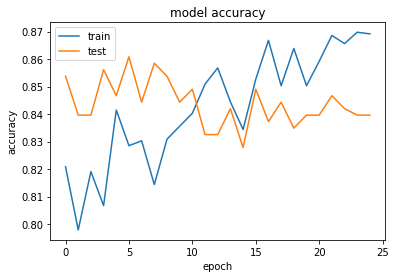

In [28]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
history = model.fit(train_datagen_flow,
                    validation_data=valid_datagen_flow, 
                    epochs=25,)

Epoch 1/25
425/425 [==============================] - 167s 359ms/step - loss: 1.6293 - accuracy: 0.3399 - val_loss: 1.2798 - val_accuracy: 0.5708
Epoch 2/25
425/425 [==============================] - 152s 357ms/step - loss: 1.2444 - accuracy: 0.5798 - val_loss: 1.1342 - val_accuracy: 0.6392
Epoch 3/25
425/425 [==============================] - 151s 355ms/step - loss: 1.1852 - accuracy: 0.6120 - val_loss: 1.0740 - val_accuracy: 0.6462
Epoch 4/25
425/425 [==============================] - 151s 356ms/step - loss: 1.0841 - accuracy: 0.6704 - val_loss: 1.0364 - val_accuracy: 0.6745
Epoch 5/25
425/425 [==============================] - 151s 355ms/step - loss: 1.0526 - accuracy: 0.7011 - val_loss: 1.1126 - val_accuracy: 0.6439
Epoch 6/25
425/425 [==============================] - 153s 360ms/step - loss: 1.0573 - accuracy: 0.6685 - val_loss: 1.0300 - val_accuracy: 0.6675
Epoch 7/25
425/425 [==============================] - 153s 361ms/step - loss: 1.0282 - accuracy: 0.6920 - val_loss: 1.0058 -

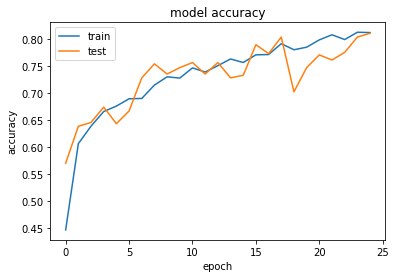

In [32]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [132]:
from sklearn.metrics import accuracy_score

In [225]:
y_pred = []
y_label = []

# for _ in range(4279//20):
labels = []
preds = []
filenames = []

# for low_prob in range(5):   
#     for step, (x_batch_train, y_batch_train) in enumerate(train_datagen_flow):
#         y_label+=[np.argmax(y) for y in y_batch_train]
#         labels+=y_batch_train.tolist()
#         pred = model.predict(x_batch_train)
#         y_pred+=[np.argmax(y) if max(y) > 0.6 else low_prob for y in pred]
#         preds+=pred.tolist()
#         filenames+=train_datagen_flow.filenames[step*120:(step+1)*120]
#         print(step)
#         if (step + 1) * 120 > 2121:break
#     print('low_prob: ', low_prob)
#     print(accuracy_score(y_label, y_pred))
#     print('---------------------')

for step, (x_batch_train, y_batch_train) in enumerate(train_datagen_flow):
    y_label+=[np.argmax(y) for y in y_batch_train]
    labels+=y_batch_train.tolist()
    pred = model.predict(x_batch_train)
    y_pred+=[np.argmax(y) for y in pred]
    preds+=pred.tolist()
    filenames+=train_datagen_flow.filenames[step*120:(step+1)*120]
    print(step)
    if (step + 1) * 120 > 2121:break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [226]:
len(y_pred)

2121

In [227]:
accuracy_score(y_label, y_pred)

0.8859028760018859

In [108]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, auc

In [65]:
names_of_disease

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [66]:
breaking_point = 0
bad_labels = []
bad_images = []
index = []
y_pred_0 = []
y_label_0 = []

for i in range(len(filenames)):
    y_pred_0.append(preds[i][0])
    y_label_0.append(labels[i][0])

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.984


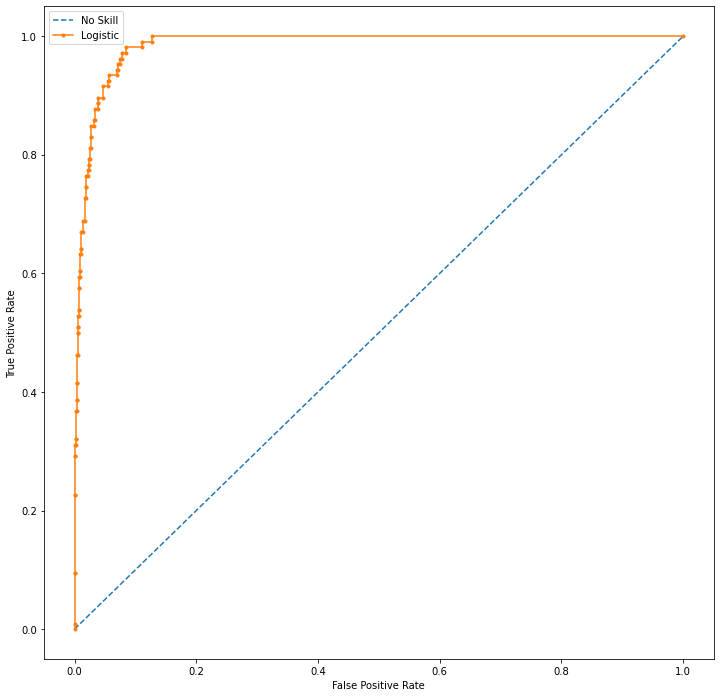

In [121]:
y_pred_0 = []
y_label_0 = []

predict_for = 0 # cbb

for i in range(len(filenames)):
    y_pred_0.append(preds[i][predict_for])
    y_label_0.append(labels[i][predict_for])
    
#predict negatrive for all
ns_probs = [0 for _ in range(len(y_label_0))]

ns_auc = roc_auc_score(y_label_0, ns_probs)
lr_auc = roc_auc_score(y_label_0, y_pred_0)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_label_0, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_label_0, y_pred_0)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.982


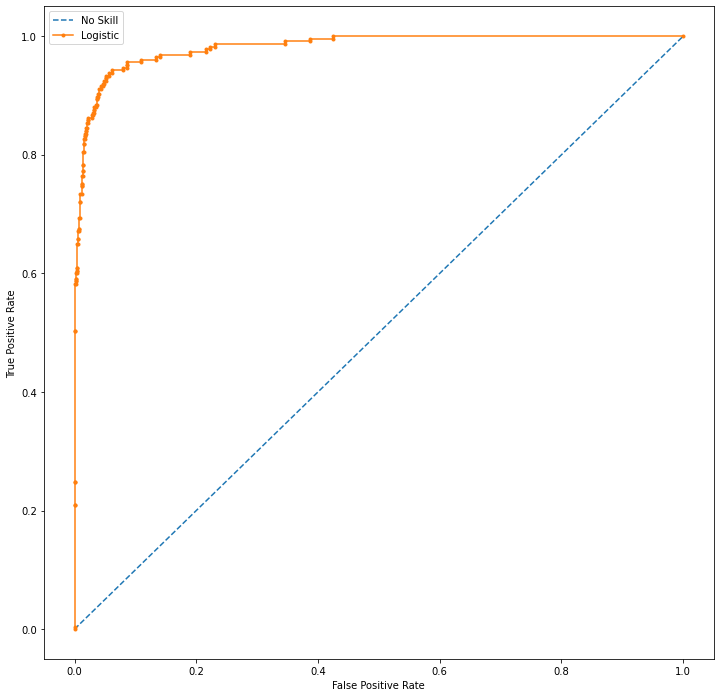

In [122]:
y_pred_0 = []
y_label_0 = []

predict_for = 1#CBSD

for i in range(len(filenames)):
    y_pred_0.append(preds[i][predict_for])
    y_label_0.append(labels[i][predict_for])
    
#predict negatrive for all
ns_probs = [0 for _ in range(len(y_label_0))]

ns_auc = roc_auc_score(y_label_0, ns_probs)
lr_auc = roc_auc_score(y_label_0, y_pred_0)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_label_0, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_label_0, y_pred_0)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.978


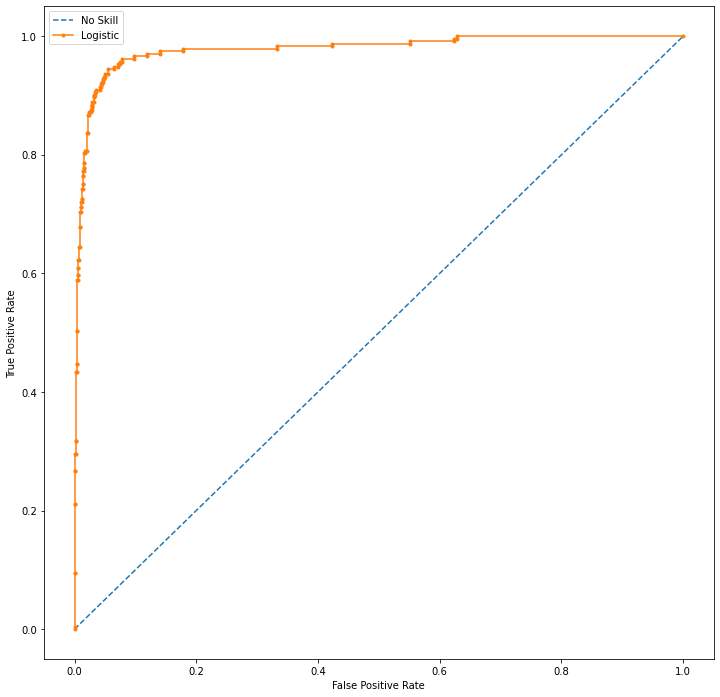

In [123]:
y_pred_0 = []
y_label_0 = []

predict_for = 2#CGM

for i in range(len(filenames)):
    y_pred_0.append(preds[i][predict_for])
    y_label_0.append(labels[i][predict_for])
    
#predict negatrive for all
ns_probs = [0 for _ in range(len(y_label_0))]

ns_auc = roc_auc_score(y_label_0, ns_probs)
lr_auc = roc_auc_score(y_label_0, y_pred_0)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_label_0, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_label_0, y_pred_0)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.983


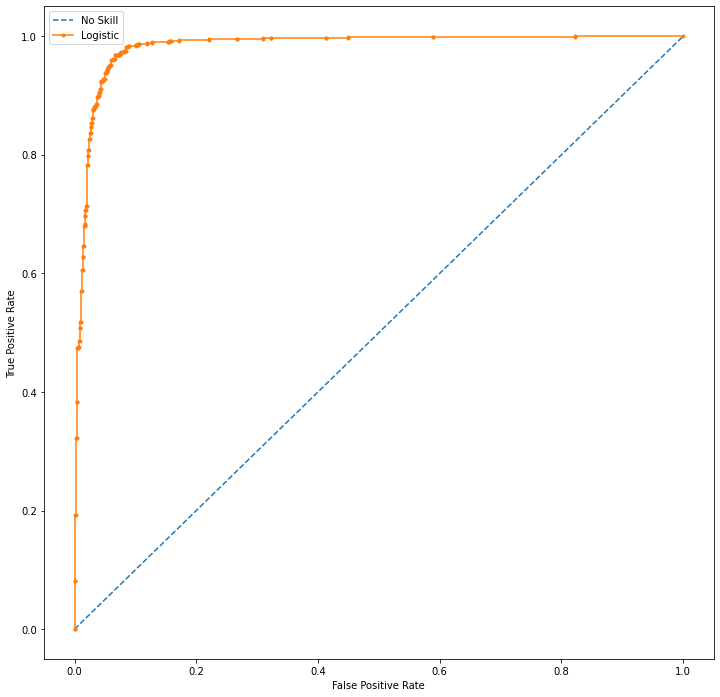

In [124]:
y_pred_0 = []
y_label_0 = []

predict_for = 3#CMD

for i in range(len(filenames)):
    y_pred_0.append(preds[i][predict_for])
    y_label_0.append(labels[i][predict_for])
    
#predict negatrive for all
ns_probs = [0 for _ in range(len(y_label_0))]

ns_auc = roc_auc_score(y_label_0, ns_probs)
lr_auc = roc_auc_score(y_label_0, y_pred_0)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_label_0, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_label_0, y_pred_0)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.959


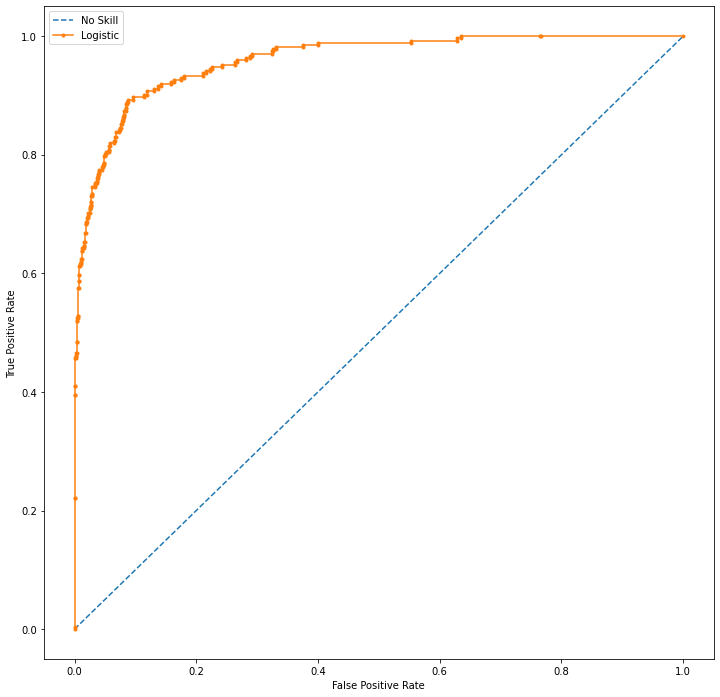

In [125]:
y_pred_0 = []
y_label_0 = []

predict_for = 4#healthy

for i in range(len(filenames)):
    y_pred_0.append(preds[i][predict_for])
    y_label_0.append(labels[i][predict_for])
    
#predict negatrive for all
ns_probs = [0 for _ in range(len(y_label_0))]

ns_auc = roc_auc_score(y_label_0, ns_probs)
lr_auc = roc_auc_score(y_label_0, y_pred_0)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_label_0, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_label_0, y_pred_0)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [109]:
y_pred_0 = []
y_label_0 = []

predict_for = 4#healthy

for i in range(len(filenames)):
    y_pred_0.append(preds[i][predict_for])
    y_label_0.append(labels[i][predict_for])

# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(y_label_0, y_pred_0)
# calculate scores
lr_f1, lr_auc = f1_score(y_label_0, y_label_0), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=1.000 auc=0.848


NameError: name 'testy' is not defined